In [9]:
import pandas as pd
import geopandas as gpd
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import contextily as cx
import numpy as np

Primero vamos a crear el diagrama de tarta, en este diagrama vamos a representar el uso de las RRSS de personas entre 16 a 65 años. datos sacados de https://www.epdata.es/uso-redes-sociales-jovenes-adultos/e4fa8227-bbac-4844-aa34-39d7948b2db8 (se han eliminado muchas RRSS poco relevantes para hacer la visualización)

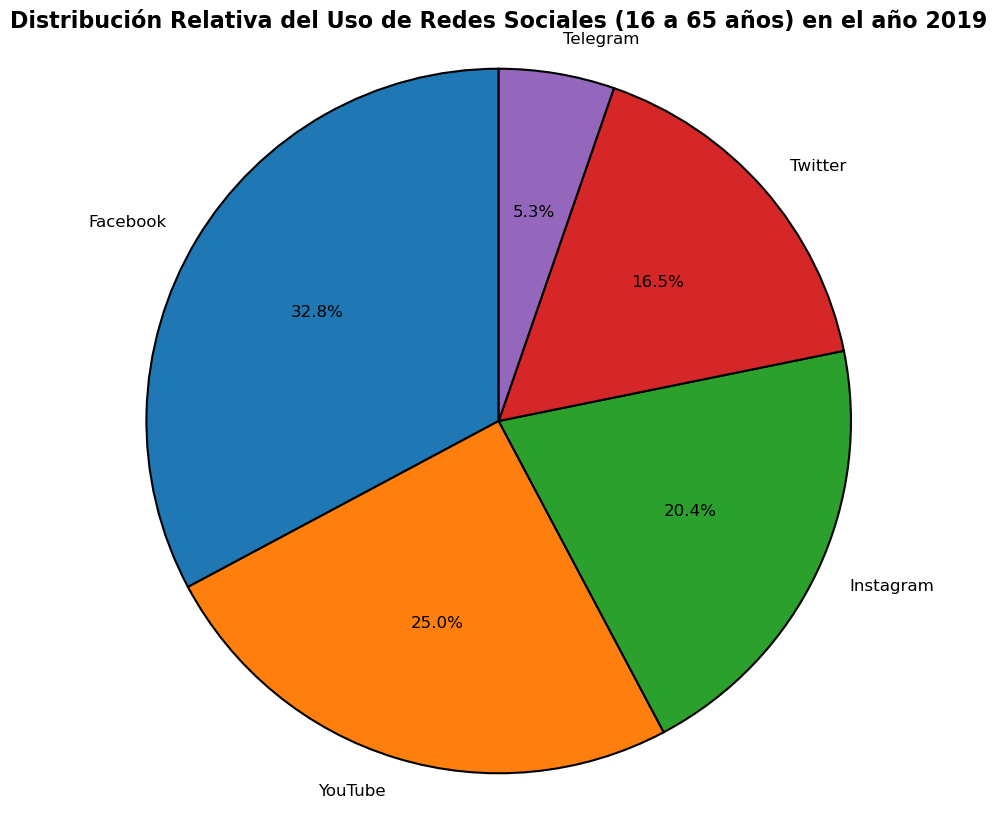

In [2]:
data = pd.read_excel("datos/datos_tarta.xlsx")
df = pd.DataFrame(data)
df["De 16 a 65 años"]= df['De 16 a 30 años'] + df['De 46 a 65 años']
etiquetas = df['Parámetro']
valores_totales = df['De 16 a 65 años']
# 3. Creación del Gráfico Circular
plt.figure(figsize=(10, 10))

plt.pie(
    valores_totales,
    labels=etiquetas,
    autopct='%1.1f%%',  # Muestra los porcentajes con un decimal
    startangle=90,      # Inicia el primer segmento (Facebook) en la parte superior
    textprops={'fontsize': 12}, # Tamaño de letra para las etiquetas
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5} # Borde para los segmentos
)

# Título de la gráfica
plt.title(
    'Distribución Relativa del Uso de Redes Sociales (16 a 65 años) en el año 2019',
    fontsize=16,
    fontweight='bold'
)

# Asegura que el gráfico sea un círculo perfecto (aspecto igual)
plt.axis('equal')

plt.show()

Ahora pasaremos con la técnica Proportional Symbol Map. Para esta visualización usaremos datos sobre la tasa de desempleo en europa este pasado septiembre de 2025 datos sacados de https://www.epdata.es/tasa-desempleo-juvenil-menores-25-anos-paises-union-europea-enero-2022/91d9c4f9-df4a-4040-bc9b-18b0d6ecae3d

In [3]:
datos = pd.read_excel("datos/datos_map.xlsx")
df_map = pd.DataFrame(datos)


In [4]:
# --- PASO 2: OBTENER GEOMETRÍAS DE PAÍSES EUROPEOS ---

# Cargar el mapa mundial de geopandas
world = gpd.read_file("datos/visualizacion_mapa/ne_110m_admin_0_countries.shp")
name_mapping = {
    'Czech Rep.': 'República Checa',
    'Ireland': 'Irlanda',
    'Netherlands': 'Países Bajos',
    'Slovak Rep.': 'Eslovaquia',
    'Lithuania': 'Lituania',
    'Latvia': 'Letonia',
    'Estonia': 'Estonia',
    'Finland': 'Finlandia',
    'Sweden': 'Suecia',
    'Denmark': 'Dinamarca',
    'Germany': 'Alemania',
    'Austria': 'Austria',
    'Belgium': 'Bélgica',
    'Luxembourg': 'Luxemburgo',
    'France': 'Francia',
    'Spain': 'España',
    'Portugal': 'Portugal',
    'Italy': 'Italia',
    'Greece': 'Grecia',
    'Bulgaria': 'Bulgaria',
    'Romania': 'Rumanía',
    'Poland': 'Polonia',
    'Hungary': 'Hungría',
    'Slovenia': 'Eslovenia',
    'Croatia': 'Croacia',
    'Cyprus': 'Chipre',
    'Malta': 'Malta'
}

world['name_mapped'] = world['SOVEREIGNT'].map(name_mapping).fillna(world['SOVEREIGNT'])

# 3. FILTRADO CORREGIDO: Usando la columna correcta del shapefile
europe_countries = world[
    world['name_mapped'].isin(df_map['Parámetro'])
].copy()

# 4. Unión y Preparación de Puntos (centroides) y escalado:
gdf_merged = europe_countries.merge(df_map, left_on='name_mapped', right_on='Parámetro', how='inner')
gdf_merged = gdf_merged.to_crs(epsg=3857)
gdf_merged['centroid'] = gdf_merged.geometry.centroid
gdf_points = gpd.GeoDataFrame(gdf_merged.drop(columns=['geometry']), geometry=gdf_merged['centroid'], crs=gdf_merged.crs)
gdf_points['Desempleo_Plot'] = gdf_points['menores de 25'].replace(0, 0.1)
gdf_points['size_scaled'] = (gdf_points['Desempleo_Plot']**0.5) * 1500
norm = Normalize(vmin=gdf_points['menores de 25'][gdf_points['menores de 25'] > 0].min(), vmax=gdf_points['menores de 25'].max())

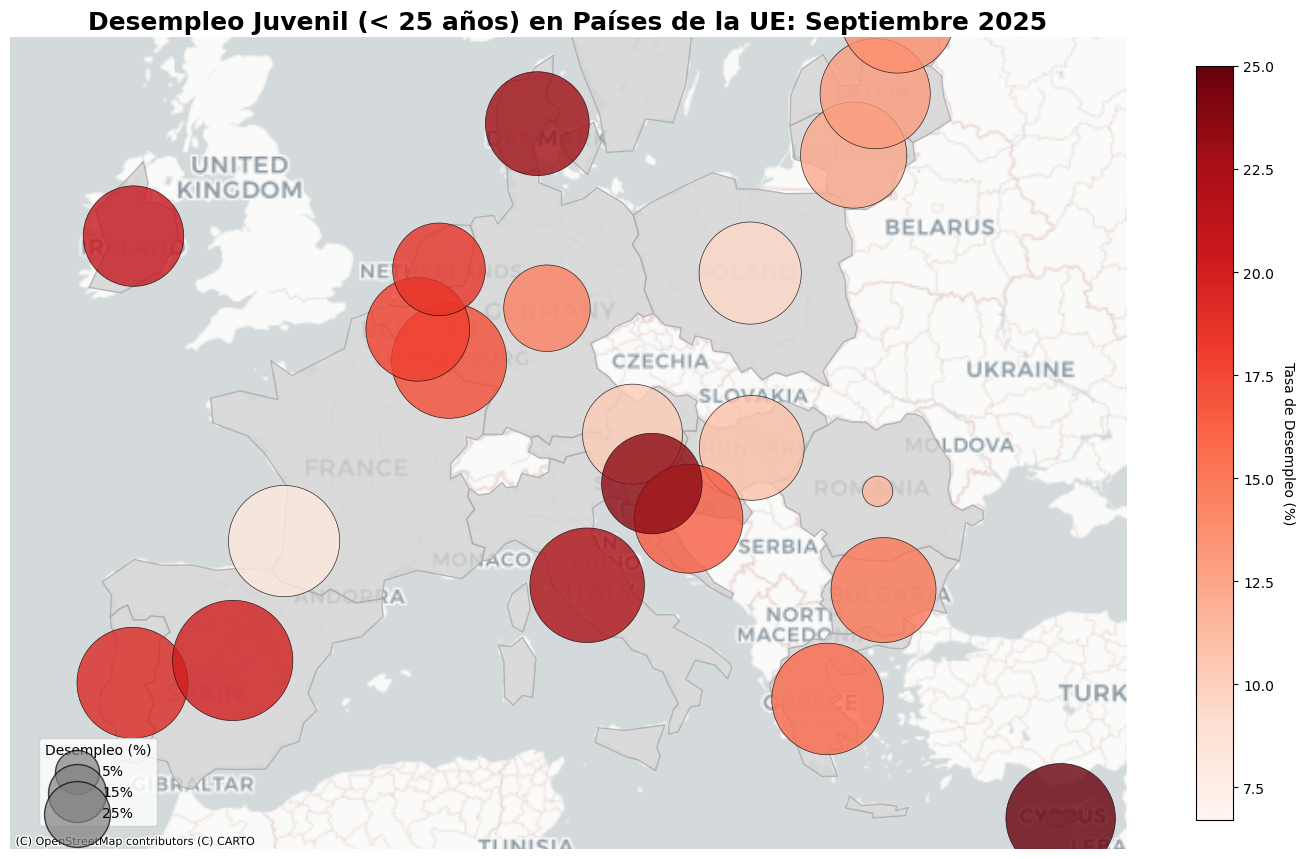

In [5]:
ig, ax = plt.subplots(1, 1, figsize=(18, 14))
europe_countries_proj = europe_countries.to_crs(epsg=3857)
europe_countries_proj.plot(ax=ax, color='lightgray', edgecolor='darkgray', alpha=0.8)

gdf_points.plot(ax=ax, marker='o', c=gdf_points['menores de 25'], cmap='Reds', markersize=gdf_points['size_scaled'], alpha=0.8, edgecolor='black', linewidth=0.5, zorder=2)

cx.add_basemap(ax, crs=gdf_points.crs.to_string(), source=cx.providers.CartoDB.Positron, zoom=4)
ax.set_xlim(-1500000, 4000000)
ax.set_ylim(4000000, 8000000)

# Leyenda de Tamaño
legend_labels = [5, 15, 25]
legend_sizes = [(val**0.5) * 450 for val in legend_labels]
legend_handles = [plt.scatter([], [], s=size, color='gray', alpha=0.7, edgecolor='black', label=f'{label}%') for size, label in zip(legend_sizes, legend_labels)]
ax.legend(handles=legend_handles, title="Desempleo (%)", loc='lower left', frameon=True, fontsize=10, bbox_to_anchor=(0.02, 0.02))

# Barra de Color
sm = plt.cm.ScalarMappable(cmap='Reds', norm=norm)
sm.set_array(gdf_points['menores de 25'][gdf_points['menores de 25'] > 0])
cbar = plt.colorbar(sm, ax=ax, orientation="vertical", shrink=0.7)
cbar.set_label('Tasa de Desempleo (%)', rotation=270, labelpad=15)

ax.set_title('Desempleo Juvenil (< 25 años) en Países de la UE: Septiembre 2025', fontsize=18, fontweight='bold')
ax.set_axis_off()
plt.show()

Para la última técnica Spiral Plot. Vamos a usar datos de temperatura máxima en España desde el 1970 al 2025. Datos extraidos de https://www.epdata.es/temperaturas-maximas-registradas-espana-mes-junio/8d4ec1f2-68d3-4b23-ac81-b39c9c81abcd

C:\Users\pedro\AppData\Local\Temp\ipykernel_22216\70543727.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap("coolwarm")


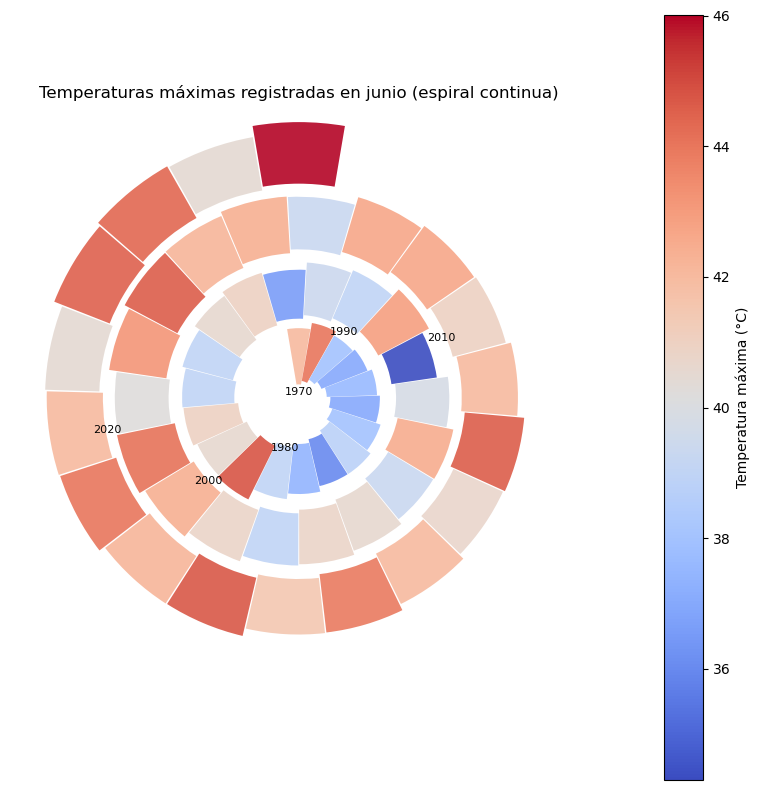

In [32]:
df = pd.read_csv("datos/datos_spiral.csv", sep=";")

df["Temperatura máxima registrada"] = df["Temperatura máxima registrada"].astype(str).str.replace(",", ".").astype(float)

# Datos
anios = df["Año"].values
temperaturas = df["Temperatura máxima registrada"].values

# Parámetros del gráfico
num_barras = len(anios)
vueltas = 3
angulos = np.linspace(0, 2 * np.pi * vueltas, num_barras)
radio_base = 1 + (angulos / (2 * np.pi)) * 5

# Colores por temperatura
norm = plt.Normalize(temperaturas.min(), temperaturas.max())
colormap = cm.get_cmap("coolwarm")
colors = colormap(norm(temperaturas))

# Crear figura polar
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 8))
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.spines['polar'].set_visible(False)

# Dibujar barras
bar_width = (2 * np.pi * vueltas) / num_barras
for i, (ang, r, temp, año, color) in enumerate(zip(angulos, radio_base, temperaturas, anios, colors)):
    ax.bar(ang, temp / 10, bottom=r, width=bar_width,
           color=color, alpha=0.9, edgecolor='none')
    
    # Mostrar etiqueta cada 10 años
    if i % 10 == 0:
        ax.text(ang, r - 0.2, str(año),
                ha='center', va='top', fontsize=8,color='black')

# Estética
ax.set_title("Temperaturas máximas registradas en junio (espiral continua)", va='bottom', fontsize=12)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.grid(False)

# Barra de color (leyenda térmica)
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.1)
cbar.set_label("Temperatura máxima (°C)")

plt.tight_layout()
plt.show()

Para buscar información en general se han consultado las webs mencionadas en el enunciado: https://www.data-to-viz.com/ , https://datavizproject.com/ y https://datavizcatalogue.com/ES/ . Para la realización del código se han consultado las siguientes:

Diagrama de tarta :

https://python-graph-gallery.com/pie-plot/
    
https://www.w3schools.com/python/matplotlib_pie_charts.asp
    
https://www.geeksforgeeks.org/data-science/plot-a-pie-chart-in-python-using-matplotlib/

Symbol map:

https://jan-46106.medium.com/plotting-maps-with-european-data-in-python-part-i-decd83837de4
    
https://stackoverflow.com/questions/67606171/how-to-plot-an-europe-map-with-my-own-data
    
https://www.naturalearthdata.com/downloads/ (Ficheros de mapas)

Spiral map:

https://stackoverflow.com/questions/28549501/plot-a-spiral-where-r-theta2-for-0-theta-10pi-in-python
    
https://www.geeksforgeeks.org/data-visualization/creating-a-temporal-range-time-series-spiral-plot/
    
https://matplotlib.org/stable/gallery/pie_and_polar_charts/polar_bar.html?utm_source=chatgpt.com
    
    